In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten,Dropout,BatchNormalization,Lambda
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Embedding
from keras.layers import LSTM,GRU,RNN
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad,Adadelta,Nadam
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model

from matplotlib import pyplot as plt 
%matplotlib inline

In [5]:
from google.colab import files
test = files.upload()

Saving facebook_health_cases (augmented).csv to facebook_health_cases (augmented).csv


In [6]:
texts = pd.read_csv('facebook_health_cases (augmented).csv')
df = pd.DataFrame(texts)
df

,date,text,cleaned,sentiment
0,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka ditambah ditolak sesuka hati rama...,negative
1,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka ditambah ditolak sesuka benda ram...,negative
2,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka menggandakan ditolak sesuka pokok...,negative
3,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka menggandakan ditolak sesuka benda...,negative
4,20210309,"""Angka semua boleh direka ditambah ditolak ses...",nombor direka menggandakan ditolak sesuka bend...,negative
...,...,...,...,...
42127,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga rakyat malaysia bersatu jangan terpisah...,positive
42128,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga rakyat malaysia bersatu jangan terpisah...,positive
42129,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga negeri malaysia bersatu jangan terpisah...,positive
42130,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga republik malaysia bersama-sama menghent...,positive


In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(df['cleaned'],df['sentiment'],test_size = 0.2,random_state = 42)

In [8]:
print("Max length: %s" %df.cleaned.str.len().max())
print("Mean length: %s" %df.cleaned.str.len().mean())
print("Min length: %s" %df.cleaned.str.len().min())

Max length: 1275
Mean length: 100.14922149435108
Min length: 3


In [70]:
MAX_SEQ_LEN = 1000
VOCAB_SIZE = 100000

num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.

In [71]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [72]:
train_sequences

[[238, 644, 88, 46, 4513],
 [70,
  14,
  147,
  7742,
  6504,
  544,
  147,
  1853,
  2998,
  261,
  34,
  3136,
  1143,
  249,
  6968,
  3644,
  668,
  106,
  1198,
  52],
 [8, 48, 2, 9428, 982, 4779],
 [575, 1481, 1351],
 [3908, 3510, 7743, 7744, 7745, 334, 89, 22, 2584, 3257, 67, 1047, 4514, 7746],
 [983,
  124,
  7747,
  1375,
  13,
  18,
  4515,
  24,
  40,
  564,
  2747,
  128,
  6969,
  268,
  8,
  11,
  5536,
  1376,
  3787,
  109,
  49,
  124,
  231,
  7748,
  331,
  1218,
  102,
  126,
  124,
  1424,
  156,
  31,
  31,
  160,
  344,
  142,
  434,
  257,
  11877,
  996,
  2999,
  3369],
 [5, 50, 145, 145],
 [954,
  7749,
  1703,
  1854,
  27,
  7413,
  955,
  305,
  2498,
  923,
  7,
  418,
  3137,
  1377,
  8,
  48,
  5537,
  1059],
 [26,
  136,
  1243,
  18,
  174,
  628,
  45,
  581,
  2193,
  2017,
  68,
  1546,
  58,
  1,
  14591,
  9429,
  4288,
  13,
  412,
  4780,
  2659],
 [400, 92, 61],
 [8,
  1321,
  212,
  113,
  1961,
  2,
  5,
  1482,
  264,
  1322,
  1122,
  283

In [73]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16097 unique tokens.


maxlen = Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence.

In [74]:
train_data = pad_sequences(train_sequences, maxlen= MAX_SEQ_LEN)
test_data = pad_sequences(test_sequences, maxlen= MAX_SEQ_LEN)
print(train_data.shape)
print(test_data.shape)

(33705, 1000)
(8427, 1000)


In [75]:
train_labels = Y_train

In [76]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)

print(label_encoder.classes_)

['negative' 'neutral' 'positive']


In [77]:
train_labels

array([0, 1, 2, ..., 1, 1, 0])

In [78]:
#convert to labels to one-hot-coded
train_tensor = to_categorical(np.array(train_labels))

print("Train tensor shape:",train_data.shape)
print("Train labels tensor shape:",train_tensor.shape)

Train tensor shape: (33705, 1000)
Train labels tensor shape: (33705, 3)


In [79]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
#cuDNN_LSTM_model.add(Lambda(lambda x: tf.expand_dims(cuDNN_LSTM_model.output, axis=-1)))
LSTM_model.add(LSTM(128 ,#activation= 'relu',
               return_sequences=True,
               name="lstm_1"
              ))
LSTM_model.add(LSTM(64 ,#activation= 'relu',
               return_sequences=False,
               name="lstm_2"
              ))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())

LSTM_model.add(Dense(128,activation= 'relu'))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dense(3,activation= 'softmax'))

In [80]:
adam = Adam(lr=0.001)
LSTM_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 128)         117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [81]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= 'val_accuracy', factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= 'val_accuracy', mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                     #restore_best_weights= True)

#file_path = "cnn4_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cudnn_lstm_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= 'val_accuracy', save_best_only=True)

In [82]:
history = LSTM_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Epoch 1/1000
422/422 [==============================] - 67s 152ms/step - loss: 12.7223 - accuracy: 0.5770 - val_loss: 1.0581 - val_accuracy: 0.6547
Epoch 2/1000
422/422 [==============================] - 63s 150ms/step - loss: 0.8545 - accuracy: 0.7761 - val_loss: 0.8965 - val_accuracy: 0.7279
Epoch 3/1000
422/422 [==============================] - 63s 150ms/step - loss: 0.7022 - accuracy: 0.8384 - val_loss: 0.9113 - val_accuracy: 0.7668
Epoch 4/1000
422/422 [==============================] - 64s 151ms/step - loss: 0.5691 - accuracy: 0.8841 - val_loss: 0.9089 - val_accuracy: 0.7692
Epoch 5/1000
422/422 [==============================] - 63s 150ms/step - loss: 0.4823 - accuracy: 0.9127 - val_loss: 0.6663 - val_accuracy: 0.8537
Epoch 6/1000
422/422 [==============================] - 63s 150ms/step - loss: 0.4670 - accuracy: 0.9204 - val_loss: 0.5744 - val_accuracy: 0.8835
Epoch 7/1000
422/422 [==============================] - 64s 151ms/step - loss: 0.4492 - accuracy: 0.9240 - val_loss: 

In [83]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

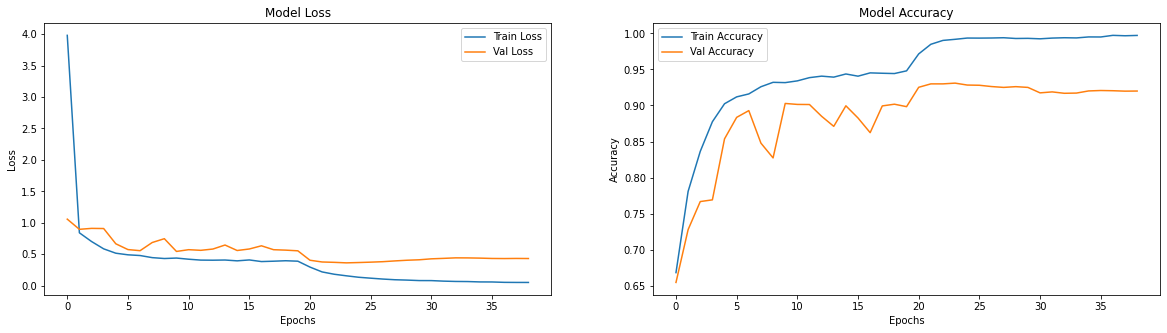

In [84]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

Evaluate model with trained LSTM

In [85]:
evaluation = LSTM_model.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

1054/1054 [==============================] - 55s 52ms/step - loss: 0.1208 - accuracy: 0.9835
Train Loss: 0.120816 Train Accuracy: 0.983474


Evaluate model with best score of trained LSTM

In [86]:
# with best weight
best_weights_lstm = load_model(file_path)
evaluation = best_weights_lstm.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

1054/1054 [==============================] - 57s 54ms/step - loss: 0.1766 - accuracy: 0.9838
Train Loss: 0.176612 Train Accuracy: 0.983801


Convert test target with one-hot encoded

In [87]:
test_labels = Y_test
label_encoder = LabelEncoder()
label_encoder.fit(Y_test)
test_labels = label_encoder.transform(test_labels)

test_tensor = to_categorical(np.array(test_labels))

Evaluate test data with trained LSTM

In [88]:
loss, accuracy = LSTM_model.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

264/264 [==============================] - 14s 53ms/step - loss: 0.4366 - accuracy: 0.9244
Testing Accuracy:  0.9244


Evaluate test data with best weight of trained LSTM

In [89]:
loss, accuracy = best_weights_lstm.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

264/264 [==============================] - 14s 53ms/step - loss: 0.3719 - accuracy: 0.9316
Testing Accuracy:  0.9316


### GRU

In [95]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

GRU_model = Sequential()
GRU_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))


#cuDNN_GRU_model.add(Lambda(lambda x: tf.expand_dims(cuDNN_GRU_model.output, axis=-1)))
GRU_model.add(GRU(128, return_sequences= True)) 
GRU_model.add(GRU(64, return_sequences= True))
GRU_model.add(GRU(32, return_sequences= False))
GRU_model.add(Dropout(0.2))
GRU_model.add(BatchNormalization())

GRU_model.add(Dense(128,activation= 'relu'))
GRU_model.add(Dropout(0.5))
GRU_model.add(BatchNormalization())
GRU_model.add(Dense(3,activation= 'softmax'))

In [96]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
GRU_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

GRU_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         10000000  
_________________________________________________________________
gru_3 (GRU)                  (None, 1000, 128)         88320     
_________________________________________________________________
gru_4 (GRU)                  (None, 1000, 64)          37248     
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [97]:
metric = 'val_accuracy'

reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                     #restore_best_weights= True)

#file_path = "cnn4_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cudnn_gru_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

In [98]:
history = GRU_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Epoch 1/1000
422/422 [==============================] - 78s 175ms/step - loss: 12.7266 - accuracy: 0.5949 - val_loss: 0.9934 - val_accuracy: 0.6689
Epoch 2/1000
422/422 [==============================] - 73s 173ms/step - loss: 0.8679 - accuracy: 0.7640 - val_loss: 0.7993 - val_accuracy: 0.7942
Epoch 3/1000
422/422 [==============================] - 74s 175ms/step - loss: 0.7742 - accuracy: 0.8150 - val_loss: 0.9394 - val_accuracy: 0.7337
Epoch 4/1000
422/422 [==============================] - 73s 174ms/step - loss: 0.6600 - accuracy: 0.8589 - val_loss: 0.8720 - val_accuracy: 0.7848
Epoch 5/1000
422/422 [==============================] - 73s 174ms/step - loss: 0.5838 - accuracy: 0.8911 - val_loss: 0.6044 - val_accuracy: 0.8794
Epoch 6/1000
422/422 [==============================] - 73s 174ms/step - loss: 0.5078 - accuracy: 0.9110 - val_loss: 0.7541 - val_accuracy: 0.8331
Epoch 7/1000
422/422 [==============================] - 73s 174ms/step - loss: 0.4813 - accuracy: 0.9199 - val_loss: 

In [99]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

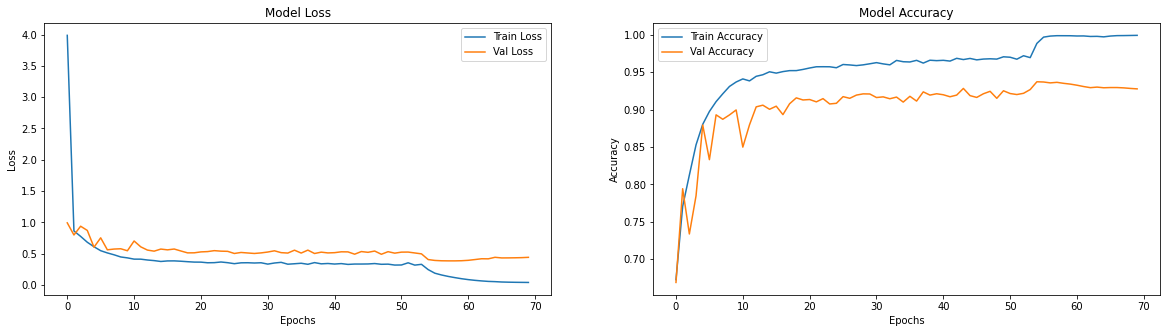

In [100]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [101]:
evaluation = GRU_model.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

1054/1054 [==============================] - 67s 63ms/step - loss: 0.1193 - accuracy: 0.9852
Train Loss: 0.119283 Train Accuracy: 0.985225


In [102]:
# with best weight
best_weights_gru = load_model(file_path)
evaluation = best_weights_gru.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

1054/1054 [==============================] - 68s 63ms/step - loss: 0.2392 - accuracy: 0.9858
Train Loss: 0.239209 Train Accuracy: 0.985759


In [103]:
loss, accuracy = GRU_model.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

264/264 [==============================] - 17s 64ms/step - loss: 0.4581 - accuracy: 0.9263
Testing Accuracy:  0.9263


In [104]:
loss, accuracy = best_weights_gru.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

264/264 [==============================] - 17s 63ms/step - loss: 0.4208 - accuracy: 0.9365
Testing Accuracy:  0.9365


In [105]:
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
files.download('cudnn_lstm_weights.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
!ls

 cudnn_gru_weights.hdf5   'facebook_health_cases (augmented).csv'
 cudnn_lstm_weights.hdf5   sample_data
